# Python for High Performance Computing
# Summary of shared memory parallel methods
<hr style="border: solid 4px green">
<br>
<center> <img src="../../images/arc_logo.png"; alt="Logo" style="float: center; width: 20%"></center>
<br>
## http://www.arc.ox.ac.uk
## support@arc.ox.ac.uk

## Making Python faster
<hr style="border: solid 4px green">

### Serial solutions
* `NumPy`
* Fortran and C
<br><br>

### Parallel solutions (shared memory porgramming)
* Fortran and C accelerated by OpenMP
* Cython
<br><br>


### Demonstrated on the 2D heat equation solution
* serial solutions (last time)
* parallel solutions

## 2D heat equation solution recap
<hr style="border: solid 4px green">

### The numerical algorithm
* start with initial conditions $u^0$
* for each time step
  * for each space point, use current solution $u^{n}$ and the 6-point stencil (below) to compute next step $u^{n+1}$
  * apply boundary conditions
<br><br>

### The 6-point stencil of the numerical scheme
* each discrete point $(i, j)$ is updated from five values
  * itself
  * 4 neighbours: $(i-1, j)$, $(i+1, j)$, $(i, j-1)$, $(i, j+1)$
<br><br>

### Implementation
* solution is a 2D array
* updated solution is another 2D array
* the two arrays are swapped at each time-step

## 2D heat equation: C + OpenMP
<hr style="border: solid 4px green">

```c
void timestep ( const double nu,
                const int nx,const int ny,
                double uo[nx][ny],double u[nx][ny] )
{

  int i,j;

  // finite difference scheme
# ifdef _OPENMP
# pragma omp parallel for      \
  default (none)               \
  shared (u,uo)                \
  private (i,j)                \
  firstprivate (nx,ny, nu)     \
  schedule (static)
# endif
  // finite difference scheme
  for (i=1; i<nx-1; i++) {
    for (j=1; j<ny-1; j++) {
      u[i][j] = uo[i][j]
              + nu * ( uo [i-1][j] + uo [i+1][j]
                     + uo [i][j-1] + uo [i][j+1]
                     - 4.0 * uo [i][j] );
        }
  }
}
```

## 2D heat equation: Fortran + OpenMP
<hr style="border: solid 4px green">

```fortran
subroutine timestep (nu, uo,u, nx,ny)
  use omp_lib

  implicit none

  integer, parameter :: dp = selected_real_kind (15, 307)

  integer,                                   intent (in)    :: nx,ny
  real (kind=dp), dimension (0:nx-1,0:ny-1), intent (inout) :: u
  real (kind=dp), dimension (0:nx-1,0:ny-1), intent (in)    :: uo
  real (kind=dp),                            intent (in)    :: nu

  integer :: i,j

  !$omp parallel do default(none) &
  !$omp&            private(i,j) shared(u,uo) &
  !$omp&            firstprivate(nx,ny, nu) collapse(2) &
  !$omp&            schedule(static)
  do j = 1, ny-2
     do i = 1, nx-2
        u(i,j) = uo(i,j)                        &
               + nu * ( uo (i-1,j) + uo (i+1,j) &
                      + uo (i,j-1) + uo (i,j+1) &
                      - 4.0_dp * uo (i,j) )
     end do
  end do
  !$omp end parallel do

end subroutine timestep
```

## 2D heat equation: Cython
<hr style="border: solid 4px green">

```python
import cython
from cython.parallel import prange, parallel
cimport openmp

@cython.boundscheck(False)
@cython.wraparound(False)
def timestep (double [:, :] u,
              double [:, :] uo,
              double nu):
    """ time-steps implemented using cython and straight python array indexing"""
    # c-style type definitions
    cdef int nx,ny
    cdef int i, j
    # array size
    nx = u.shape[0]
    ny = u.shape[1]
    # apply numerical scheme (one time-step)
    for i in prange(1, nx-1, nogil=True):
        for j in range(1, ny-1):
            u[i,j] = uo[i,j] + ( nu * ( uo [i-1, j] + uo [i+1, j] +
                                        uo [i, j-1] + uo [i, j+1]
                                        - 4.0 * uo [i,j] ) )
```

## 2D heat equation: build libraries
<hr style="border: solid 4px green">

In [1]:
# C and Fortran extensions
msg = !python setup_c_fortran.py config_fc --f90flags="-O3 -mavx -fopenmp" install --prefix=$PWD

In [2]:
# cython extensions
msg = !python setup_cython.py install --prefix=$PWD

## 2D heat equation: check
<hr style="border: solid 4px green">

In [3]:
!ls -l ./lib/python2.7/site-packages

total 472
-rwxr-xr-x  1 mihai  staff    9376  7 Mar 13:33 c_stepper.so
-rwxr-xr-x  1 mihai  staff  176360  7 Mar 13:33 cython_stepper.so
-rwxr-xr-x  1 mihai  staff   37220  7 Mar 13:33 fortran_stepper.so
drwxr-xr-x  3 mihai  staff     102  7 Mar 13:33 fortran_stepper.so.dSYM
-rw-r--r--  1 mihai  staff     250  7 Mar 13:33 heat_c_fortran_stepper-0.0.0-py2.7.egg-info
-rw-r--r--  1 mihai  staff     247  7 Mar 13:33 heat_cython_stepper-0.0.0-py2.7.egg-info


## 2D heat equation: run
<hr style="border: solid 4px green">

In [4]:
!for nt in 1 2 4; do echo "===== $nt threads ====="; OMP_NUM_THREADS=$nt python heat.py 1000 500; done

===== 1 threads =====
 computing 500 iterations on a 1000x1000 grid
 stepper numpy, 500 iterations, 5.252281 seconds, 0.382189 rel error
 stepper fortran, 500 iterations, 1.367225 seconds, 0.382189 rel error
 stepper ctypes, 500 iterations, 0.536755 seconds, 0.382189 rel error
 stepper cython, 500 iterations, 1.859913 seconds, 0.382285 rel error
===== 2 threads =====
 computing 500 iterations on a 1000x1000 grid
 stepper numpy, 500 iterations, 5.231704 seconds, 0.382189 rel error
 stepper fortran, 500 iterations, 0.784759 seconds, 0.382189 rel error
 stepper ctypes, 500 iterations, 0.369377 seconds, 0.382189 rel error
 stepper cython, 500 iterations, 1.028648 seconds, 0.382285 rel error
===== 4 threads =====
 computing 500 iterations on a 1000x1000 grid
 stepper numpy, 500 iterations, 5.288416 seconds, 0.382189 rel error
 stepper fortran, 500 iterations, 0.418362 seconds, 0.382189 rel error
 stepper ctypes, 500 iterations, 0.311398 seconds, 0.382189 rel error
 stepper cython, 500 itera

## 2D heat equation: results on the ARC cluster
<hr style="border: solid 4px green">

### Compute nodes
* 16 cores (Intel Xeon Haswell)
* 64GB RAM (or more)

```
for nt in 1 2 4 6 8 10 12 14 16; do
  OMP_NUM_THREADS=$nt python heat.py 3000 500;
done 2>&1 | tee heat.3000x3000x500_arcus-b.raw
```

In [8]:
!grep seconds heat.3000x3000x500_arcus-b.raw | awk '{print $5}' > heat.3000x3000x500_arcus-b.times

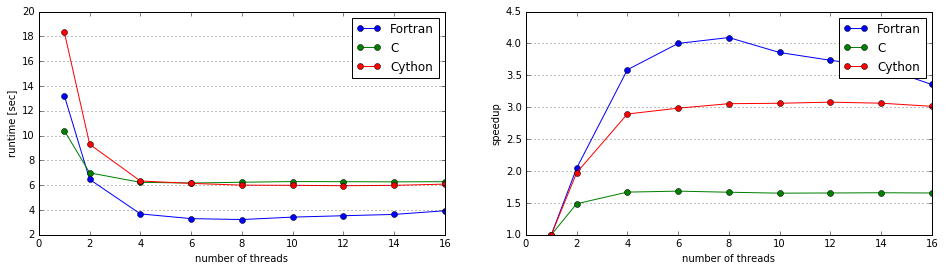

In [5]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
data = np.loadtxt ("heat.3000x3000x500_arcus-b.times")
data = data.reshape([-1,4])
nthreads = np.array([1, 2, 4, 6, 8, 10, 12, 14, 16])

# control figure size
plt.figure (figsize = (16, 4))

# plot 1: wallclock time
plt.subplot (1, 2, 1)
plt.plot (nthreads, data[:,1], 'bo-', label="Fortran")
plt.plot (nthreads, data[:,2], 'go-', label="C")
plt.plot (nthreads, data[:,3], 'ro-', label="Cython")
plt.xlabel ("number of threads")
plt.ylabel ("runtime [sec]")
axes = plt.gca ()
axes.yaxis.grid ()
plt.legend ()

# plot 2: speedup
plt.subplot (1, 2, 2)
plt.plot (nthreads, data[0,1] / data[:,1], 'bo-', label="Fortran")
plt.plot (nthreads, data[0,2] / data[:,2], 'go-', label="C")
plt.plot (nthreads, data[0,3] / data[:,3], 'ro-', label="Cython")
plt.xlabel ("number of threads")
plt.ylabel ("speedup")
axes = plt.gca ()
axes.yaxis.grid ()
plt.legend ()

# show plot
plt.show ()

## Conclusions
<hr style="border: solid 4px green">

### A number of parallel solutions on a realistic problem
* C and Fortran extensions using OpenMP
* `cython`
<br><br>

### Overall winner: <span style="font-family: Courier New, Courier, monospace;">cython</span>
* easy to use and mature
* shared memory parallelism also easy

<img src="../../images/reusematerial.png"; style="float: center; width: 90"; >